In [1]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense, Activation, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, GlobalMaxPooling2D


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_path = '/kaggle/input/garbage-classification-v2/Garbage Classification'

def load_dataset(path, target_shape):
    class_folders = os.listdir(path)
    filenames = []
    labels = []

    for i, class_folder in enumerate(class_folders):
        folder_path = os.path.join(path, class_folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            try:
                image = cv2.imread(image_path)
                if image is None:
                    continue  # Skip non-image files
                resized_image = cv2.resize(image, target_shape[:2])
                filenames.append(resized_image)
                labels.append(i)
            except Exception as e:
                print(f"Error processing image: {image_path} - {e}")

    X = np.array(filenames)
    y = np.array(labels)

    # Normalize pixel values
    X = X.astype('float32') / 255.0

    # Convert labels to categorical
    y = np_utils.to_categorical(y)

    return X, y


# Define the target shape for resizing images
target_shape = (110, 110, 3)

# Load and preprocess the dataset
X, y = load_dataset(train_path, target_shape)

# Split the dataset into training, testing, and validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Shape of X_train, y_train:", X_train.shape, y_train.shape)
print("Shape of X_test, y_test:", X_test.shape, y_test.shape)
print("Shape of X_val, y_val:", X_val.shape, y_val.shape)

    

libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk
libpng warning: Out of place sRGB chunk


Shape of X_train, y_train: (15827, 110, 110, 3) (15827, 10)
Shape of X_test, y_test: (4397, 110, 110, 3) (4397, 10)
Shape of X_val, y_val: (1759, 110, 110, 3) (1759, 10)


In [3]:
# Define the model architecture
MainInput = Input(shape=target_shape)
dn169 = DenseNet201(weights='imagenet', include_top=False, input_shape=target_shape, pooling='avg')(MainInput)
reshape = Reshape((8,8,30))(dn169)

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D


def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='softmax')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x


conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)

image_size_2 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)

conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)

conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))

conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)

image_size_3 = 4
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256) 


conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)

conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv = Dense(y_train.shape[1], activation="softmax")(conv)

model_dn169 = Model(inputs=MainInput, outputs=conv)
model_dn169.summary()

74836368/74836368 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 110, 110, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet201 (Functional)       (None, 1920)         18321984    ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 30)     0           ['densenet201[0][0]']            
                                                                                                  
 conv2d (Conv2D)             

In [4]:
# Compile the model
model_dn169.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, epsilon=0.1), metrics=['accuracy'])

# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, min_delta=0.001)

# Record the start time
import time
start_time = time.time()

# Train the model
history = model_dn169.fit(X_train, y_train,
                          epochs=1,
                          batch_size=12,
                          validation_data=(X_val, y_val),
                          callbacks=[checkpoint, early_stopping])

# Calculate the total training time
end_time = time.time()
total_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(total_time))

1319/1319 [==============================] - 168s 102ms/step - loss: 1.4338 - accuracy: 0.5228 - val_loss: 0.7942 - val_accuracy: 0.7470
Total training time: 172.42 seconds


Number of epochs trained: 1


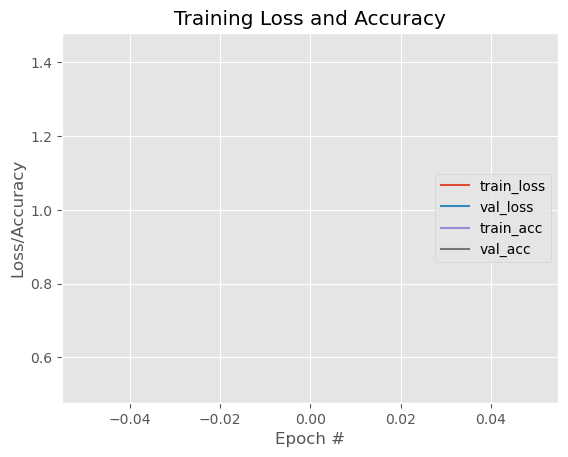

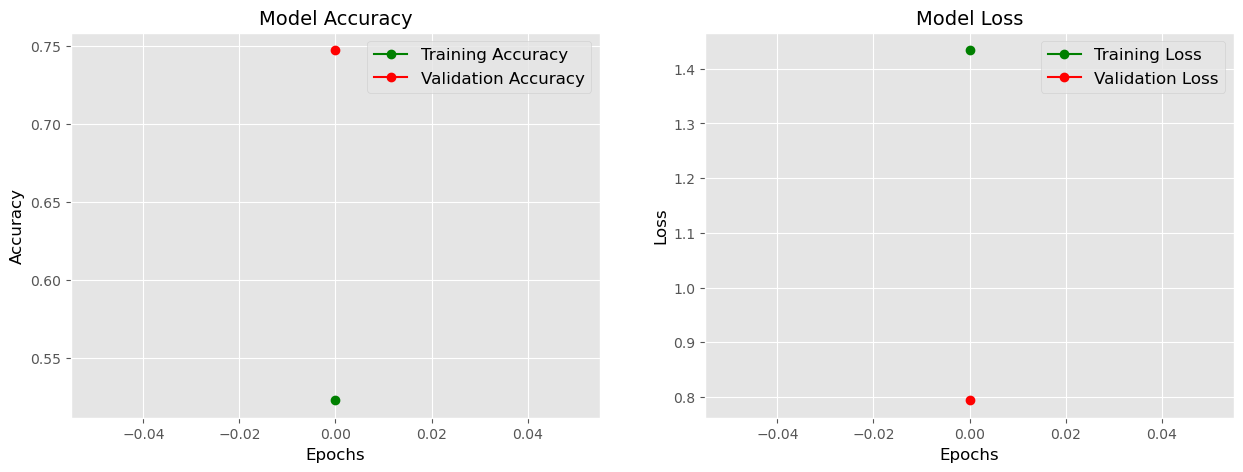

In [5]:
# Load the best weights
model_dn169.load_weights('/kaggle/working/model.h5')

# Plot the training loss and accuracy
N = len(history.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("DenseNet169_Model")

# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

# History plotting
epochs = [i for i in range(num_epochs_trained)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15, 5)

# Plotting accuracy
ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
title_font = {'fontname': 'Times New Roman', 'size': '14', 'color': 'black', 'weight': 'normal'}
ax[0].set_title('Model Accuracy', fontdict=title_font)
legend_font = {'family': 'Times New Roman', 'size': '12', 'weight': 'normal'}
ax[0].legend(prop=legend_font)
label_font = {'fontname': 'Times New Roman', 'size': '12', 'color': 'black', 'weight': 'normal'}
ax[0].set_xlabel("Epochs", fontdict=label_font)
ax[0].set_ylabel("Accuracy", fontdict=label_font)

# Plotting loss
ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Model Loss', fontdict=title_font)
ax[1].legend(prop=legend_font)
ax[1].set_xlabel("Epochs", fontdict=label_font)
ax[1].set_ylabel("Loss", fontdict=label_font)

plt.show()

In [6]:
# Evaluate the model on the test set
val_loss, val_accuracy = model_dn169.evaluate(X_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)




Test loss: 0.7394185662269592
Test accuracy: 0.7659767866134644


In [7]:
# Make predictions on the test set
y_pred = model_dn169.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)

report = classification_report(y_test_labels, y_pred)
print(report)


138/138 [==============================] - 10s 43ms/step
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       346
           1       0.76      0.77      0.76       792
           2       0.87      0.71      0.78       235
           3       0.68      0.68      0.68       421
           4       0.92      0.65      0.76       185
           5       0.44      0.78      0.56       132
           6       0.61      0.83      0.70       389
           7       0.95      0.69      0.80       387
           8       0.94      0.94      0.94      1065
           9       0.76      0.55      0.64       445

    accuracy                           0.77      4397
   macro avg       0.75      0.73      0.73      4397
weighted avg       0.79      0.77      0.77      4397



In [8]:
import pickle

# Save the trained model
model_dn169.save('model_dn169.h5')

# Save the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train.argmax(axis=1))
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)


In [9]:
!pip install Flask


In [23]:
import cv2
import numpy as np
import pickle
from keras.models import load_model
from flask import Flask, request, jsonify

app = Flask(__name__)

# Load the model and label encoder from the dataset
model_path = '/kaggle/working/model_dn169.h5'
label_encoder_path = '/kaggle/working/label_encoder.pkl'

model_dn169 = load_model(model_path)
with open(label_encoder_path, 'rb') as f:
    label_encoder = pickle.load(f)

# Helper function to preprocess the image
def preprocess_image(image):
    target_shape = (110, 110, 3)
    image = cv2.resize(image, target_shape[:2])
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255.0
    return image

@app.route('/', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'}), 400

    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400

    try:
        image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_UNCHANGED)
        preprocessed_image = preprocess_image(image)
        prediction = model_dn169.predict(preprocessed_image)
        predicted_class_idx = np.argmax(prediction)
        predicted_label = label_encoder.classes_[predicted_class_idx]
        return jsonify({'label': predicted_label})
    except Exception as e:
        return jsonify({'error': str(e)}), 500

# The HTML template as a string
html_template = '''
<!DOCTYPE html>
<html>
<head>
    <title>Garbage Classification</title>
</head>
<body>
    <h1>Garbage Classification</h1>
    <form action="/" method="post" enctype="multipart/form-data">
        <input type="file" name="file" id="file">
        <input type="submit" value="Upload Image">
    </form>
    <div>
        <p>Predicted Class Label: <span id="predicted_label"></span></p>
    </div>
    <script>
        const form = document.querySelector('form');
        form.addEventListener('submit', async (e) => {
            e.preventDefault();
            const fileInput = document.getElementById('file');
            const formData = new FormData();
            formData.append('file', fileInput.files[0]);

            const response = await fetch('/', {
                method: 'POST',
                body: formData,
            });

            if (response.ok) {
                const data = await response.json();
                document.getElementById('predicted_label').textContent = data.label;
            } else {
                alert('Error occurred during prediction.');
            }
        });
    </script>
</body>
</html>
'''

@app.route('/', methods=['GET'])
def index():
    return html_template
!netstat -tuln | grep 8888
!kill -9 PID

if __name__ == '__main__':
    app.run(debug=True, port=8889)




/bin/bash: line 1: netstat: command not found
/bin/bash: line 1: kill: PID: arguments must be process or job IDs
 * Serving Flask app '__main__'
 * Debug mode: on


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1042, in launch_instance
    app.initialize(argv)
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 113, in inner
    return method(app, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 678, in initialize
    self.init_sockets()
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 317, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)
  File "/opt/conda/lib/python3.10/site-packages/

SystemExit: 1